In [0]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 460kB 15.4MB/s 
     |████████████████████████████████| 112kB 18.2MB/s 
     |████████████████████████████████| 102kB 7.2MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=051fa6c1896702b76de1fc4ea22b6e66c0e95482645336c191169e65e0af3440
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=a59cde549192b10a275c0d3ce11ac36a2d692550509396b99d1fd9c0761447d2
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=ceef

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
#import cv2
#from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import wandb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

from wandb.keras import WandbCallback

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
! wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: a4ab5d8a6171fab0904b85d2244903a17e38dab8
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/Car Classification/dataset.zip" -d '/content'

In [0]:
os.listdir('/content/dataset')

['train',
 'test',
 'labels_val.csv',
 'labels_train.csv',
 'labels_test.csv',
 'val']

In [0]:
data_path = os.path.join(os.getcwd(), 'dataset')

train_df = pd.read_csv(os.path.join(data_path, 'labels_train.csv'))
val_df = pd.read_csv(os.path.join(data_path, 'labels_val.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'labels_test.csv'))

In [0]:
train_df.head()

,file_name,labels
0,00px849_0.jpeg,toyota avanza
1,00pr438_0.jpeg,toyota avanza
2,00qf715_1.jpeg,toyota avanza
3,00px849_1.jpeg,toyota avanza
4,00pr438_1.jpeg,toyota avanza


In [0]:
print('Num Classes in Train: ', len(np.unique(train_df['labels'])))
print('Num Classes in Val: ', len(np.unique(val_df['labels'])))
print('Num Classes in Test: ', len(np.unique(test_df['labels'])))

Num Classes in Train:  18
Num Classes in Val:  18
Num Classes in Test:  18


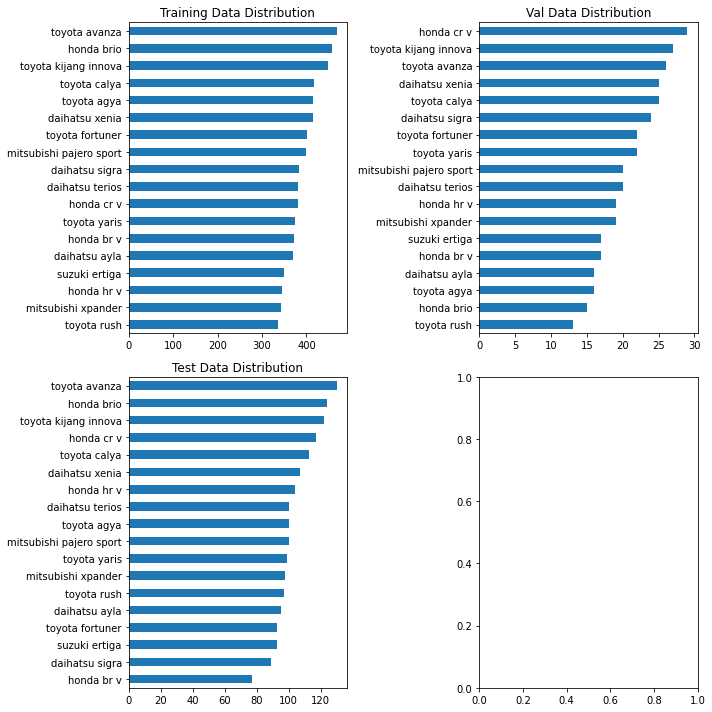

In [0]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

fig.sca(ax[0][0])
train_df['labels'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Training Data Distribution')

fig.sca(ax[0][1])
val_df['labels'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Val Data Distribution')

fig.sca(ax[1][0])
test_df['labels'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Test Data Distribution')

fig.tight_layout()

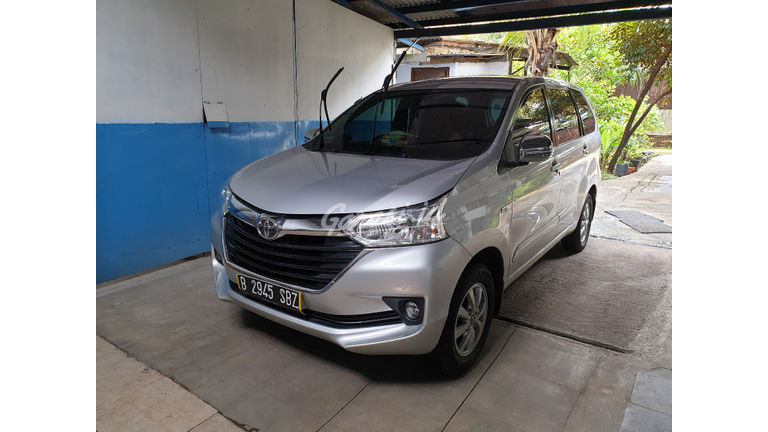

toyota avanza


In [0]:
im = Image.open(os.path.join(data_path, 'train', train_df['file_name'][0]))
display(im)
print(train_df['labels'][0])

**Data Preprocessing**

In [0]:
# need to do label encoding of labels here
all_labels = np.unique(train_df['labels'])
all_labels.sort()

models_to_num = {}
for ind, elem in enumerate(all_labels):
    models_to_num[elem] = ind

num_to_models = {value:key for key, value in models_to_num.items()}

In [0]:
models_to_num

{'daihatsu ayla': 0,
 'daihatsu sigra': 1,
 'daihatsu terios': 2,
 'daihatsu xenia': 3,
 'honda br v': 4,
 'honda brio': 5,
 'honda cr v': 6,
 'honda hr v': 7,
 'mitsubishi pajero sport': 8,
 'mitsubishi xpander': 9,
 'suzuki ertiga': 10,
 'toyota agya': 11,
 'toyota avanza': 12,
 'toyota calya': 13,
 'toyota fortuner': 14,
 'toyota kijang innova': 15,
 'toyota rush': 16,
 'toyota yaris': 17}

In [0]:
num_to_models

{0: 'daihatsu ayla',
 1: 'daihatsu sigra',
 2: 'daihatsu terios',
 3: 'daihatsu xenia',
 4: 'honda br v',
 5: 'honda brio',
 6: 'honda cr v',
 7: 'honda hr v',
 8: 'mitsubishi pajero sport',
 9: 'mitsubishi xpander',
 10: 'suzuki ertiga',
 11: 'toyota agya',
 12: 'toyota avanza',
 13: 'toyota calya',
 14: 'toyota fortuner',
 15: 'toyota kijang innova',
 16: 'toyota rush',
 17: 'toyota yaris'}

In [0]:
train_df.head()

,file_name,labels
0,00px849_0.jpeg,toyota avanza
1,00pr438_0.jpeg,toyota avanza
2,00qf715_1.jpeg,toyota avanza
3,00px849_1.jpeg,toyota avanza
4,00pr438_1.jpeg,toyota avanza


In [0]:
# create image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center = True,
    #featurewise_std_normalization = True, 
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# automatically encode labels in alphabetical order
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory= os.path.join(data_path, 'train'),
    x_col = 'file_name',
    y_col = 'labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32, 
    shuffle = True,
    seed = 42)

# validation_generator = test_datagen.flow_from_dataframe(
#     val_df,
#     directory = os.path.join(data_path, 'val'),
#     x_col = 'file_name',
#     y_col = 'labels',
#     target_size = (224, 224),
#     color_mode = 'rgb',
#     class_mode = 'categorical',
#     batch_size = 32, 
#     shuffle = True,
#     seed = 50)

# test_generator = test_datagen.flow_from_dataframe(
#     test_df,
#     directory = os.path.join(data_path, 'test'),
#     x_col = 'file_name',
#     y_col = 'labels',
#     target_size = (224, 224),
#     color_mode = 'rgb',
#     class_mode = 'categorical',
#     batch_size = 32, 
#     shuffle = True,
#     seed = 50)

Found 7058 validated image filenames belonging to 18 classes.


In [0]:
train_generator.class_indices

In [0]:
def read_test_img(dataelems, data_type):
      ans = np.ones((dataelems.shape[0], 224, 224, 3))

      for ind, elem in enumerate(dataelems['file_name']):
          im = Image.open(os.path.join(data_path, data_type, elem)).convert('RGB')
          im = im.resize((224, 224), Image.ANTIALIAS)
          ans[ind] = im

      return ans 

In [0]:
# read validation and test images
X_val = read_test_img(val_df, 'val')
X_test = read_test_img(test_df, 'test')

X_val = X_val / 255
X_test = X_test / 255

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [0]:
# one hot encode labels
y_val = np.array(val_df['labels'])
y_test = np.array(test_df['labels'])

# convert to integers
for x in range(len(y_val)):
  y_val[x] = models_to_num[y_val[x]]
for x in range(len(y_test)):
  y_test[x] = models_to_num[y_test[x]]

y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [0]:
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

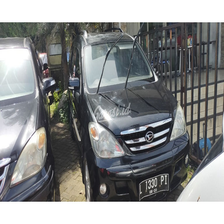

daihatsu xenia


In [0]:
im = Image.fromarray(np.uint8(X_val[10] * 255), mode='RGB')
display(im)
print(num_to_models[np.where(y_val[10] == 1)[0][0]])

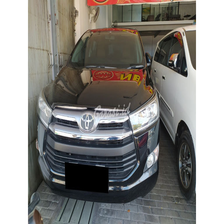

toyota kijang innova


In [0]:
im = Image.fromarray(np.uint8(X_test[0] * 255), mode='RGB')
display(im)
print(num_to_models[np.where(y_test[0] == 1)[0][0]])

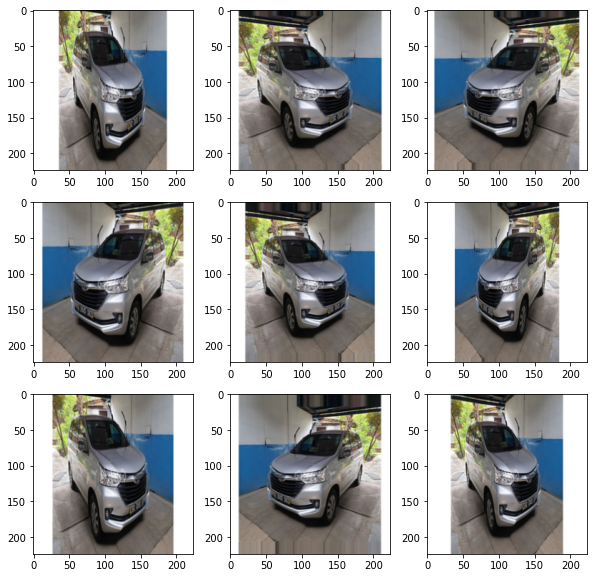

In [0]:
i = 0
plt.figure(figsize=(10,10))

test_img = Image.open(os.path.join(data_path, 'train', train_df['file_name'][0]))
test_img = test_img.resize((224, 224), Image.ANTIALIAS)
test_img = np.array(test_img)
test_img = test_img.reshape((-1, 224, 224, 3))

train_datagen.fit(test_img, augment = True)

for img_batch in train_datagen.flow(test_img, batch_size=9):
    for img in img_batch:        
        ax = plt.subplot(3,3 ,i+1)
        im = ax.imshow(img)
        i = i + 1
        
    if i >= 9:
        break

**Training Model**

In [0]:
y_test_converted  = []

for elem in y_test:
    index = np.where(elem == 1)[0][0]
    y_test_converted.append(num_to_models[index])

In [0]:
def do_prediction(model, data):
    y_pred = []

    for ind, elem in enumerate(data):
        pred = model.predict_classes(data[ind:ind+1,:,:,:])
        y_pred.append(num_to_models[pred[0]])
    
    return y_pred

In [0]:
def generate_conf_mat_df(y_true, y_pred, normalize = 'true'):
    conf_mat = confusion_matrix(y_true, y_pred, normalize = normalize)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in list(models_to_num.keys())],
                  columns = [i for i in list(models_to_num.keys())])

    df_cm = df_cm * 100
    df_cm = df_cm.round(1)
    return df_cm

**ResNet50**

In [0]:
# weights and biases initialization
# Initilize a new wandb run
wandb.init(project="Car Classification", name = 'ResNet50')

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.batch_size = 32
config.activation = 'relu'
config.optimizer = 'adam'

In [0]:
# define model architecture
model = models.Sequential()

model.add(tf.keras.applications.ResNet50(weights='imagenet', include_top= False, input_shape=(224, 224, 3)))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(18, activation = 'softmax')) #Num unique classes = 18

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

In [0]:
# save model to json
model_json = model.to_json()
with open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'Resnet50.json'), "w") as json_file:
    json_file.write(model_json)
    

# model checkpointing
checkpoint = ModelCheckpoint(
    filepath=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'Resnet50.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)

# learning rate scheduler
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

# list of callbacks
callbacks_list = [checkpoint, earlystop, LearningRateScheduler(scheduler), WandbCallback()]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# fit model
history = model.fit(
      x = train_generator,
      batch_size = 32,
      steps_per_epoch = 220,  # 7068 images = batch_size * steps
      epochs=100,
      validation_data = (X_val, y_val),
      verbose=1,
      callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
220/220 [==============================] - 141s 640ms/step - loss: 2.9664 - accuracy: 0.1079 - val_loss: 3.6294 - val_accuracy: 0.0538 - lr: 0.0010
Epoch 2/100
220/220 [==============================] - 134s 608ms/step - loss: 2.5386 - accuracy: 0.2088 - val_loss: 3.1611 - val_accuracy: 0.0457 - lr: 0.0010
Epoch 3/100
220/220 [==============================] - 132s 602ms/step - loss: 2.1560 - accuracy: 0.3089 - val_loss: 3.9171 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 4/100
220/220 [==============================] - 135s 615ms/step - loss: 1.8504 - accuracy: 0.4068 - val_loss: 2.7761 - val_accuracy: 0.1855 - lr: 0.0010
Epoch 5/100
220/220 [==============================] - 130s 590ms/step - loss: 1.4331 - accuracy: 0.5406 - val_loss: 4.8397 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/100
220/220 [==============================] - 132s 599ms/step - loss: 1.3501 - accuracy: 0.5660 - val_loss: 3.9723 - val_accuracy: 0.3091 - lr: 0.0010
Epoch 7/100
220/220 [===================

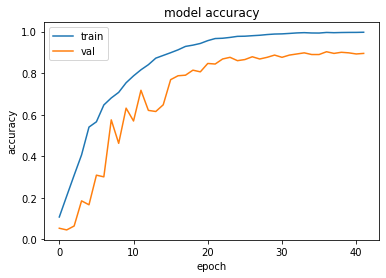

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
y_pred = do_prediction(model, X_test)
print('Accuracy Score: ', accuracy_score(y_test_converted, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy Score:  0.9085037674919269


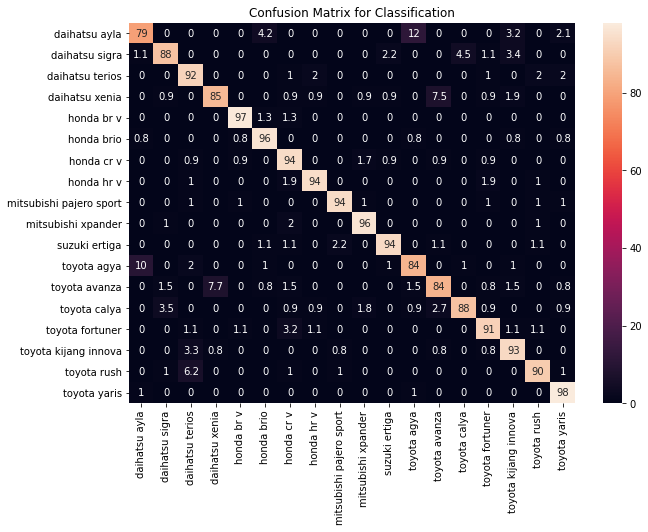

In [0]:
df_cm = generate_conf_mat_df(y_test_converted, y_pred)

plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for Classification')
sns.heatmap(df_cm, annot=True)

**VGG16**

In [0]:
# weights and biases initialization
# Initilize a new wandb run
wandb.init(project="Car Classification", name = 'VGG16')

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.batch_size = 32
config.activation = 'relu'
config.optimizer = 'adam'

In [0]:
# define model architecture
model2 = models.Sequential()

model2.add(tf.keras.applications.VGG16(weights='imagenet', include_top= False, input_shape=(224, 224, 3)))

model2.add(layers.Flatten())
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())

model2.add(layers.Dense(18, activation = 'softmax')) #Num unique classes = 18

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# save model to json
model_json = model2.to_json()
with open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'VGG16.json'), "w") as json_file:
    json_file.write(model_json)
    
# model checkpointing
checkpoint = ModelCheckpoint(
    filepath=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'VGG16.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)

# learning rate scheduler
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

# list of callbacks
callbacks_list = [checkpoint, earlystop, LearningRateScheduler(scheduler), WandbCallback()]

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# automatically encode labels in alphabetical order
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory= os.path.join(data_path, 'train'),
    x_col = 'file_name',
    y_col = 'labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32, 
    shuffle = True,
    seed = 42)

Found 7058 validated image filenames belonging to 18 classes.


In [0]:
# fit model
history = model2.fit(
      x = train_generator,
      batch_size = 32,
      steps_per_epoch = 220,  # 7068 images = batch_size * steps
      epochs=100,
      validation_data = (X_val, y_val),
      verbose=1,
      callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
220/220 [==============================] - 137s 621ms/step - loss: 3.0062 - accuracy: 0.0867 - val_loss: 4.2661 - val_accuracy: 0.0618 - lr: 0.0010
Epoch 2/100
220/220 [==============================] - 135s 615ms/step - loss: 2.8213 - accuracy: 0.1065 - val_loss: 2.9827 - val_accuracy: 0.0726 - lr: 0.0010
Epoch 3/100
220/220 [==============================] - 133s 605ms/step - loss: 2.7555 - accuracy: 0.1287 - val_loss: 3.7502 - val_accuracy: 0.0457 - lr: 0.0010
Epoch 4/100
220/220 [==============================] - 133s 605ms/step - loss: 2.7038 - accuracy: 0.1466 - val_loss: 3.6046 - val_accuracy: 0.0887 - lr: 0.0010
Epoch 5/100
220/220 [==============================] - 133s 603ms/step - loss: 2.6733 - accuracy: 0.1543 - val_loss: 16.4464 - val_accuracy: 0.0403 - lr: 0.0010
Epoch 6/100
220/220 [==============================] - 133s 604ms/step - loss: 2.6214 - accuracy: 0.1707 - val_loss: 18.6913 - val_accuracy: 0.0806 - lr: 0.0010
Epoch 7/100
220/220 [=================

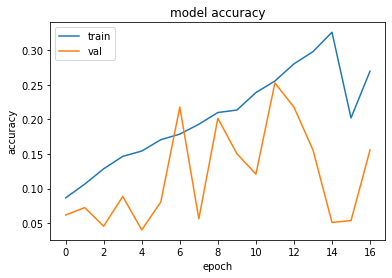

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
y_pred = do_prediction(model2, X_test)
print('Accuracy Score: ', accuracy_score(y_test_converted, y_pred))

Accuracy Score:  0.22228202368137784


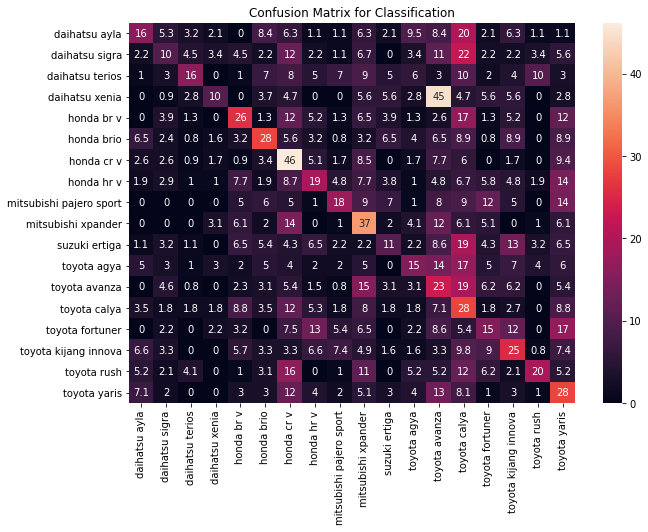

In [0]:
df_cm = generate_conf_mat_df(y_test_converted, y_pred)

plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for Classification')
sns.heatmap(df_cm, annot=True)

**InceptionV3**

In [0]:
# weights and biases initialization
# Initilize a new wandb run
wandb.init(project="Car Classification", name = 'InceptionV3')

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.batch_size = 32
config.activation = 'relu'
config.optimizer = 'adam'

In [0]:
# define model architecture
model3 = models.Sequential()

model3.add(tf.keras.applications.InceptionV3(weights='imagenet', include_top= False, input_shape=(224, 224, 3)))

model3.add(layers.Flatten())
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(rate=0.2))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(rate=0.2))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.BatchNormalization())

model3.add(layers.Dense(18, activation = 'softmax')) #Num unique classes = 18

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# save model to json
model_json = model3.to_json()
with open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'InceptionV3.json'), "w") as json_file:
    json_file.write(model_json)
    
# model checkpointing
checkpoint = ModelCheckpoint(
    filepath=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'InceptionV3.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)

# learning rate scheduler
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

# list of callbacks
callbacks_list = [checkpoint, earlystop, LearningRateScheduler(scheduler), WandbCallback()]

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# automatically encode labels in alphabetical order
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory= os.path.join(data_path, 'train'),
    x_col = 'file_name',
    y_col = 'labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32, 
    shuffle = True,
    seed = 42)

Found 7058 validated image filenames belonging to 18 classes.


In [0]:
# fit model
history = model3.fit(
      x = train_generator,
      batch_size = 32,
      steps_per_epoch = 220,  # 7068 images = batch_size * steps
      epochs=100,
      validation_data = (X_val, y_val),
      verbose=1,
      callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
220/220 [==============================] - 131s 594ms/step - loss: 3.0398 - accuracy: 0.0665 - val_loss: 13.2949 - val_accuracy: 0.0780 - lr: 0.0010
Epoch 2/100
220/220 [==============================] - 130s 591ms/step - loss: 2.8456 - accuracy: 0.0884 - val_loss: 2.8412 - val_accuracy: 0.0860 - lr: 0.0010
Epoch 3/100
220/220 [==============================] - 125s 567ms/step - loss: 2.6816 - accuracy: 0.1304 - val_loss: 44.0852 - val_accuracy: 0.0403 - lr: 0.0010
Epoch 4/100
220/220 [==============================] - 126s 571ms/step - loss: 2.4090 - accuracy: 0.2067 - val_loss: 3.4640 - val_accuracy: 0.0941 - lr: 0.0010
Epoch 5/100
220/220 [==============================] - 122s 555ms/step - loss: 2.0746 - accuracy: 0.3061 - val_loss: 3.7596 - val_accuracy: 0.0753 - lr: 0.0010
Epoch 6/100
220/220 [==============================] - 125s 570ms/step - loss: 2.0888 - accuracy: 0.3064 - val_loss: 8.9329 - val_accuracy: 0.1989 - lr: 0.0010
Epoch 7/100
220/220 [=================

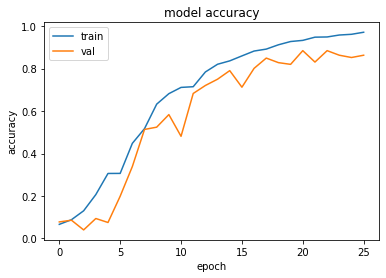

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
y_pred = do_prediction(model3, X_test)
print('Accuracy Score: ', accuracy_score(y_test_converted, y_pred))

Accuracy Score:  0.88751345532831


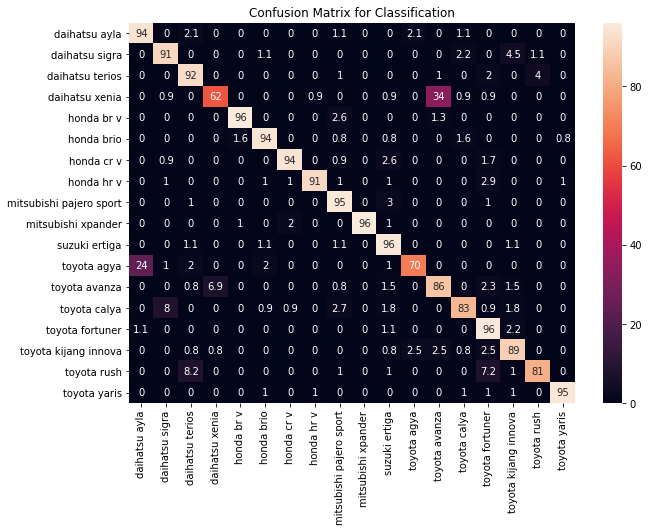

In [0]:
df_cm = generate_conf_mat_df(y_test_converted, y_pred)

plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for Classification')
sns.heatmap(df_cm, annot=True)

**MobileNetV2**

In [0]:
# weights and biases initialization
# Initilize a new wandb run
wandb.init(project="Car Classification", name = 'MobileNetV2')

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.batch_size = 32
config.activation = 'relu'
config.optimizer = 'adam'

In [0]:
# define model architecture
model4 = models.Sequential()

model4.add(tf.keras.applications.MobileNetV2(weights='imagenet', include_top= False, input_shape=(224, 224, 3)))

model4.add(layers.Flatten())
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(rate=0.2))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(rate=0.2))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.BatchNormalization())

model4.add(layers.Dense(18, activation = 'softmax')) #Num unique classes = 18

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# save model to json
model_json = model3.to_json()
with open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'MobileNetV2.json'), "w") as json_file:
    json_file.write(model_json)
    
# model checkpointing
checkpoint = ModelCheckpoint(
    filepath=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'MobileNetV2.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)

# learning rate scheduler
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

# list of callbacks
callbacks_list = [checkpoint, earlystop, LearningRateScheduler(scheduler), WandbCallback()]

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# automatically encode labels in alphabetical order
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory= os.path.join(data_path, 'train'),
    x_col = 'file_name',
    y_col = 'labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32, 
    shuffle = True,
    seed = 42)

Found 7058 validated image filenames belonging to 18 classes.


In [0]:
# fit model
history = model4.fit(
      x = train_generator,
      batch_size = 32,
      steps_per_epoch = 220,  # 7068 images = batch_size * steps
      epochs=100,
      validation_data = (X_val, y_val),
      verbose=1,
      callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
220/220 [==============================] - 131s 596ms/step - loss: 2.5107 - accuracy: 0.2525 - val_loss: 5.1429 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 2/100
220/220 [==============================] - 129s 588ms/step - loss: 1.1600 - accuracy: 0.6250 - val_loss: 5.9044 - val_accuracy: 0.1022 - lr: 0.0010
Epoch 3/100
220/220 [==============================] - 131s 594ms/step - loss: 0.7562 - accuracy: 0.7481 - val_loss: 4.5362 - val_accuracy: 0.1694 - lr: 0.0010
Epoch 4/100
220/220 [==============================] - 128s 580ms/step - loss: 0.6083 - accuracy: 0.7956 - val_loss: 5.4458 - val_accuracy: 0.1048 - lr: 0.0010
Epoch 5/100
220/220 [==============================] - 130s 592ms/step - loss: 0.5296 - accuracy: 0.8282 - val_loss: 3.2198 - val_accuracy: 0.3172 - lr: 0.0010
Epoch 6/100
220/220 [==============================] - 127s 577ms/step - loss: 0.4838 - accuracy: 0.8479 - val_loss: 3.6083 - val_accuracy: 0.2151 - lr: 0.0010
Epoch 7/100
220/220 [===================

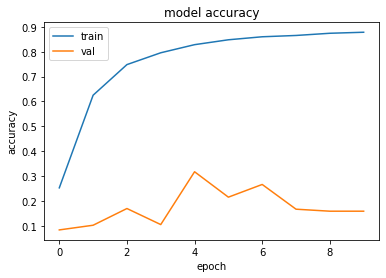

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
y_pred = do_prediction(model4, X_test)
print('Accuracy Score: ', accuracy_score(y_test_converted, y_pred))

Accuracy Score:  0.3240043057050592


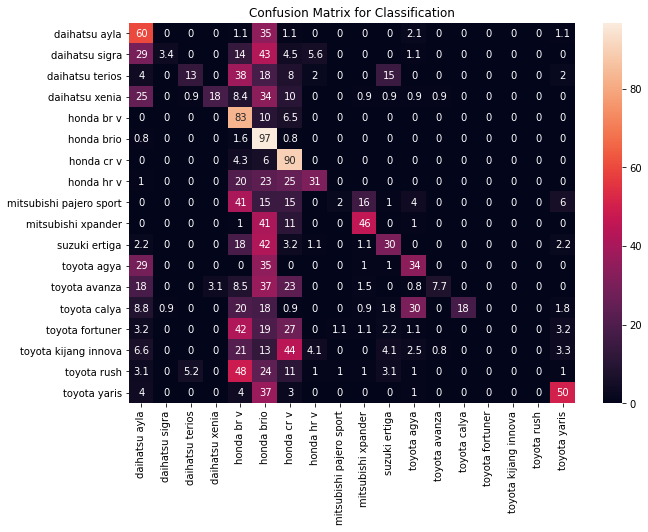

In [0]:
df_cm = generate_conf_mat_df(y_test_converted, y_pred)

plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for Classification')
sns.heatmap(df_cm, annot=True)

In [0]:
# load json and create model
json_file = open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'Resnet50.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model2 = model_from_json(loaded_model_json)
# load weights into new model
model2.load_weights(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Car Classification', 'output', 'Resnet50.h5'))
print("Loaded model from disk")

Loaded model from disk


In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
y_pred = model.predict_classes(X_test[3:4,:,:,:], batch_size=32, verbose=1)

1/1 [==============================] - 0s 1ms/step


In [0]:
num_to_models[y_pred[0]]

'honda cr v'

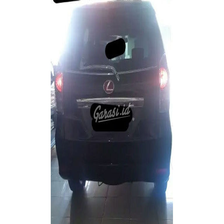

daihatsu xenia


In [0]:
im = Image.fromarray(np.uint8(X_test[3] * 255), mode='RGB')
display(im)
print(num_to_models[np.where(y_test[3] == 1)[0][0]])